# Water Temperature Estimation for Triathlon Events

This notebook implements a model for estimating water temperatures at triathlon swim segments. It uses geographic location, seasonal data, and environmental parameters to estimate realistic water temperatures.

The model uses a combination of:
- Geographic location analysis (latitude/longitude)
- Seasonal adjustment
- Environmental factors (air temperature, solar radiation, wind speed)
- Water body type consideration (coastal vs inland)

## Import Required Libraries

First, we'll import all the necessary libraries for data manipulation, visualization, and date handling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns  # For better visualization

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")  # Use a colorblind-friendly palette

## Utility Functions

Here we define the core functions required for water temperature estimation.

In [2]:
def get_season(month, lat):
    """Return hemisphere-aware season based on month and latitude"""
    if lat >= 0:  # Northern Hemisphere
        return {12: 'winter', 1: 'winter', 2: 'winter',
                3: 'spring', 4: 'spring', 5: 'spring',
                6: 'summer', 7: 'summer', 8: 'summer',
                9: 'fall', 10: 'fall', 11: 'fall'}.get(month)
    else:  # Southern Hemisphere
        return {12: 'summer', 1: 'summer', 2: 'summer',
                3: 'fall', 4: 'fall', 5: 'fall',
                6: 'winter', 7: 'winter', 8: 'winter',
                9: 'spring', 10: 'spring', 11: 'spring'}.get(month)

In [3]:
def estimate_water_temperature(row):
    """Estimate water temperature using all available environmental data"""
    # Basic location and temporal data
    lat = row['latitude']
    lon = row['longitude']
    date = datetime.strptime(row['Date'], '%m/%d/%Y')
    month = date.month
    season = get_season(month, lat)
    
    # Environmental factors with fallbacks
    solar_rad = row.get('solar_radiation', 0)
    wind_speed = row.get('average_wind_speed', 0)
    cloud_cover = row.get('cloud_coverage', 0)
    max_temp = row.get('max_temperature', 20)
    min_temp = row.get('min_temperature', max_temp - 5)
    air_temp_avg = (max_temp + min_temp) / 2
    
    # Adjust solar radiation for cloud cover - more realistic attenuation
    effective_solar = solar_rad * (1 - (cloud_cover/100)**0.7) if not pd.isna(cloud_cover) else solar_rad
    
    # Extended coastal regions configuration with more precise temperature ranges
    coastal_regions = [
        # Mediterranean Sea
        (30, 45, -5, 35, {'summer': 23, 'winter': 14, 'spring': 18, 'fall': 20}),
        # North Atlantic (European Coast)
        (45, 60, -10, 10, {'summer': 17, 'winter': 8, 'spring': 12, 'fall': 14}),
        # Caribbean/Gulf of Mexico
        (15, 30, -100, -60, {'summer': 26, 'winter': 23, 'spring': 24, 'fall': 25}),
        # US East Coast
        (25, 45, -80, -60, {'summer': 23, 'winter': 13, 'spring': 17, 'fall': 21}),
        # Australia (East Coast)
        (-40, -10, 145, 155, {'summer': 24, 'winter': 18, 'spring': 21, 'fall': 22}),
        # Pacific Northwest
        (40, 55, -130, -122, {'summer': 15, 'winter': 8, 'spring': 11, 'fall': 13}),
        # Northern Europe (Baltic Sea)
        (50, 65, 10, 30, {'summer': 16, 'winter': 5, 'spring': 10, 'fall': 12}),
        # South Pacific
        (-30, -10, 160, 180, {'summer': 25, 'winter': 20, 'spring': 22, 'fall': 23}),
        # Great Lakes Region 
        (41, 49, -93, -76, {'summer': 21, 'winter': 5, 'spring': 12, 'fall': 17}),
    ]
    
    # Check coastal regions - now with smaller solar effect coefficient
    for region in coastal_regions:
        lat_min, lat_max, lon_min, lon_max, temps = region
        if (lat_min <= lat <= lat_max) and (lon_min <= lon <= lon_max):
            base_temp = temps.get(season, 20)
            
            # Reduced environmental adjustments to avoid extreme values
            solar_effect = effective_solar * 0.008  # 0.8°C per 100 W/m² (reduced from 1.5°C)
            wind_effect = wind_speed * 0.08  # 0.08°C per m/s (reduced from 0.1°C)
            
            # Calculate more realistic water temperature
            water_temp = base_temp + solar_effect - wind_effect
            
            # Add small random variation but avoid hitting max values too often
            final_temp = water_temp + np.random.normal(0, 0.3)  # Reduced standard deviation
            
            return np.clip(final_temp, 4, 28)  # Expanded range, lower maximum
    
    # Inland water calculation (lakes/rivers) - revised approach
    # Determine water type based on location elevation if available
    elevation = row.get('location_elevation', 0)
    
    # Higher elevations tend to have colder water
    if elevation > 1000:
        water_type_factor = 6  # High mountain lakes
    elif elevation > 500:
        water_type_factor = 5  # Mountain lakes
    else:
        water_type_factor = 3  # Lowland lakes (reduced from 4)
    
    # Reduced sensitivity to solar radiation for inland water bodies
    solar_effect = effective_solar * 0.01  # 1°C per 100 W/m² (reduced from 2°C)
    wind_effect = wind_speed * 0.12  # 0.12°C per m/s (reduced from 0.15°C)
    
    # Temperature calculation with stronger relationship to air temperature
    base_water_temp = air_temp_avg - water_type_factor
    water_temp = base_water_temp + solar_effect - wind_effect
    
    # Random variation with smaller standard deviation
    final_temp = water_temp + np.random.normal(0, 0.5)  # Reduced from 1.0
    
    # More conservative clipping with lower maximum
    return np.clip(final_temp, 4, 28)  # Expanded minimum, reduced maximum

In [4]:
def diagnose_temperature_distribution(df, column='water_temperature', show_plot=True, save_plot=False):
    """Analyze the distribution of water temperatures"""
    temps = df[column].dropna()
    
    print(f"\nDiagnostics for {column}:")
    print(f"Min: {temps.min():.1f}°C, Max: {temps.max():.1f}°C")
    print(f"Mean: {temps.mean():.1f}°C, Median: {temps.median():.1f}°C")
    print(f"Std Dev: {temps.std():.2f}")
    
    # Count how many values are at or near the maximum
    max_threshold = 27.5
    max_count = (temps >= max_threshold).sum()
    max_pct = max_count / len(temps) * 100
    print(f"Values ≥ {max_threshold}°C: {max_count} ({max_pct:.1f}%)")
    
    # Distribution by ranges
    ranges = [(0, 10), (10, 15), (15, 20), (20, 25), (25, 30)]
    for low, high in ranges:
        count = ((temps >= low) & (temps < high)).sum()
        pct = count / len(temps) * 100
        print(f"{low}-{high}°C: {count} ({pct:.1f}%)")
    
    if show_plot:
        # Better histogram visualization with KDE curve
        plt.figure(figsize=(12, 6))
        
        # Left subplot: Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(temps, bins=20, kde=True, color='skyblue', edgecolor='black')
        plt.title('Water Temperature Distribution')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Frequency')
        plt.grid(alpha=0.3)
        
        # Right subplot: Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=temps, color='lightgreen')
        plt.title('Water Temperature Box Plot')
        plt.xlabel('Temperature (°C)')
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('water_temp_distribution.png')
            print("\nHistogram saved to 'water_temp_distribution.png'")
        
        plt.show()

## Data Loading and Exploration

Let's load the solar radiation data files for both full Ironman and 70.3 races, which will serve as our input data.

In [5]:
# Load the Ironman full-distance data
try:
    df_ironman = pd.read_csv('S4_Ironman_with_solar_radiation.csv')
    print(f"Loaded Ironman dataset with {len(df_ironman)} races")
    print(df_ironman.columns.tolist())
    print(df_ironman[['Date', 'Location', 'Race']].head())
except Exception as e:
    print(f"Could not load Ironman data: {str(e)}")

Loaded Ironman dataset with 306 races
['Date', 'Location', 'Race', 'longitude', 'latitude', 'location_elevation', 'bike_elevation', 'run_elevation', 'max_temperature', 'temperature_10AM', 'min_temperature', 'relative_humidity', 'average_wind_speed', 'average_pressure', 'cloud_coverage', 'water_temperature', 'solar_radiation', 'WBGT']
        Date             Location                     Race
0  6/26/2016  Klagenfurt, Austria          Ironman Austria
1  6/18/2023  Klagenfurt, Austria          Ironman Austria
2  9/19/2021  Klagenfurt, Austria  Ironman Austria-Kärnten
3   7/7/2019  Klagenfurt, Austria          Ironman Austria
4   7/3/2022  Klagenfurt, Austria          Ironman Austria


In [6]:
# Load the 70.3 half-distance data
try:
    df_703 = pd.read_csv('S4_70.3_with_solar_radiation.csv')
    print(f"\nLoaded 70.3 dataset with {len(df_703)} races")
    print(df_703.columns.tolist())
    print(df_703[['Date', 'Location', 'Race']].head())
except Exception as e:
    print(f"Could not load 70.3 data: {str(e)}")


Loaded 70.3 dataset with 613 races
['Date', 'Location', 'Race', 'longitude', 'latitude', 'location_elevation', 'bike elevation', 'run elevation', 'max_temperature', 'temperature_10AM', 'min_temperature', 'relative_humidity', 'average_wind_speed', 'average_pressure', 'cloud_coverage', 'water_temperature', 'solar_radiation', 'WBGT']
        Date                                  Location  \
0   4/8/2018  Lake Eva Park, Haines City, Florida, USA   
1  8/26/2018                      Zell am See, Austria   
2  7/10/2022                           Sandnes, Norway   
3  9/18/2021                         Jönköping, Sweden   
4  5/29/2022        Victoria, British Columbia, Canada   

                       Race  
0      Ironman 70.3 Florida  
1  Ironman 70.3 Zell am See  
2      Ironman 70.3 Sandnes  
3    Ironman 70.3 Jönköping  
4     Ironman 70.3 Victoria  


In [7]:
# Check for missing values in key columns
def check_missing_values(df, dataset_name):
    print(f"\nMissing values in {dataset_name}:")
    
    # Calculate percentage of missing values
    missing = df.isna().sum()
    missing_pct = (missing / len(df) * 100).round(1)
    
    # Create a DataFrame to display the results
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    
    # Only show columns with missing values
    return missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

# Check both datasets
try:
    print(check_missing_values(df_ironman, "Ironman"))
    print("\n" + "-" * 50)
    print(check_missing_values(df_703, "70.3"))
except Exception as e:
    print(f"Error analyzing missing values: {str(e)}")


Missing values in Ironman:
                   Missing Values  Percentage
water_temperature             306       100.0
WBGT                          306       100.0
bike_elevation                  3         1.0
run_elevation                   3         1.0

--------------------------------------------------

Missing values in 70.3:
                    Missing Values  Percentage
water_temperature              613       100.0
WBGT                           613       100.0
run elevation                   12         2.0
max_temperature                  9         1.5
temperature_10AM                 9         1.5
min_temperature                  9         1.5
relative_humidity                9         1.5
average_wind_speed               9         1.5
average_pressure                 9         1.5
cloud_coverage                   9         1.5
bike elevation                   4         0.7
latitude                         1         0.2


## Water Temperature Estimation

Now we'll apply our model to estimate water temperatures for both datasets.

Estimating water temperatures for Ironman races...

Diagnostics for water_temperature:
Min: 4.0°C, Max: 28.0°C
Mean: 19.3°C, Median: 19.5°C
Std Dev: 4.60
Values ≥ 27.5°C: 14 (4.6%)
0-10°C: 5 (1.6%)
10-15°C: 51 (16.7%)
15-20°C: 115 (37.6%)
20-25°C: 102 (33.3%)
25-30°C: 33 (10.8%)


c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Histogram saved to 'water_temp_distribution.png'


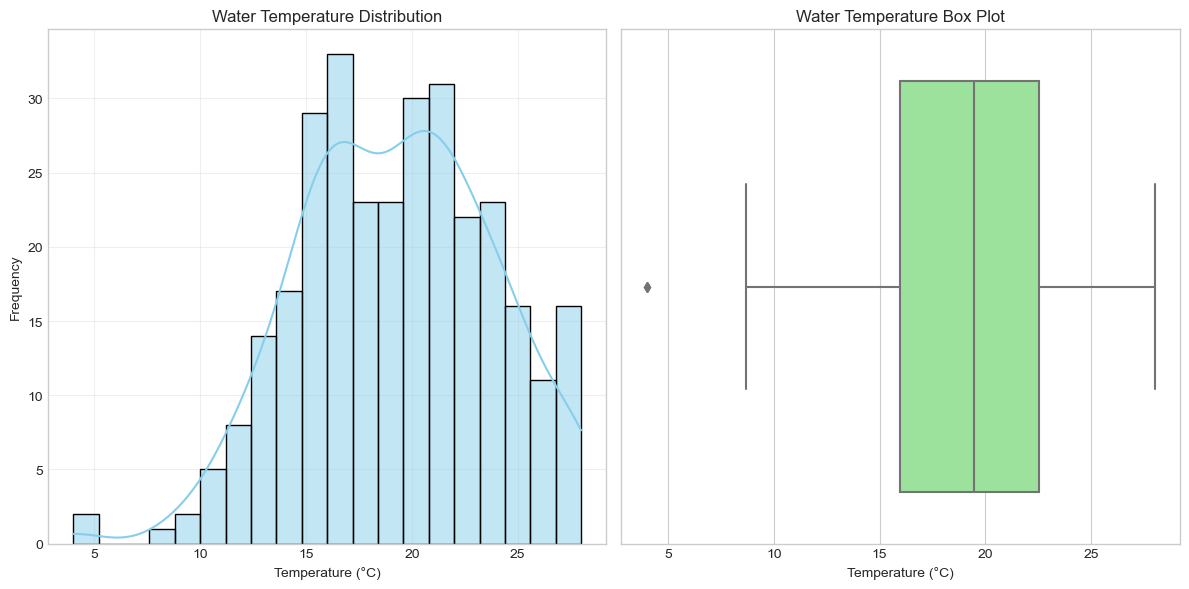

Results saved to S5_Ironman_with_Water_temp.csv


In [8]:
# Process the full Ironman dataset
if 'df_ironman' in locals():
    print("Estimating water temperatures for Ironman races...")
    
    # Create a copy to avoid warnings
    ironman_processed = df_ironman.copy()
    
    # Apply our estimation function
    ironman_processed['water_temperature'] = ironman_processed.apply(
        estimate_water_temperature, axis=1)
    
    # Analyze the resulting distribution
    diagnose_temperature_distribution(ironman_processed, save_plot=True)
    
    # Save the results
    output_file = 'S5_Ironman_with_Water_temp.csv'
    ironman_processed.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
else:
    print("Ironman dataset not available for processing")


Estimating water temperatures for 70.3 races...

Diagnostics for water_temperature:
Min: 4.0°C, Max: 28.0°C
Mean: 19.9°C, Median: 20.4°C
Std Dev: 4.92
Values ≥ 27.5°C: 33 (5.5%)
0-10°C: 14 (2.3%)
10-15°C: 84 (13.9%)
15-20°C: 187 (31.0%)
20-25°C: 225 (37.3%)
25-30°C: 94 (15.6%)


c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


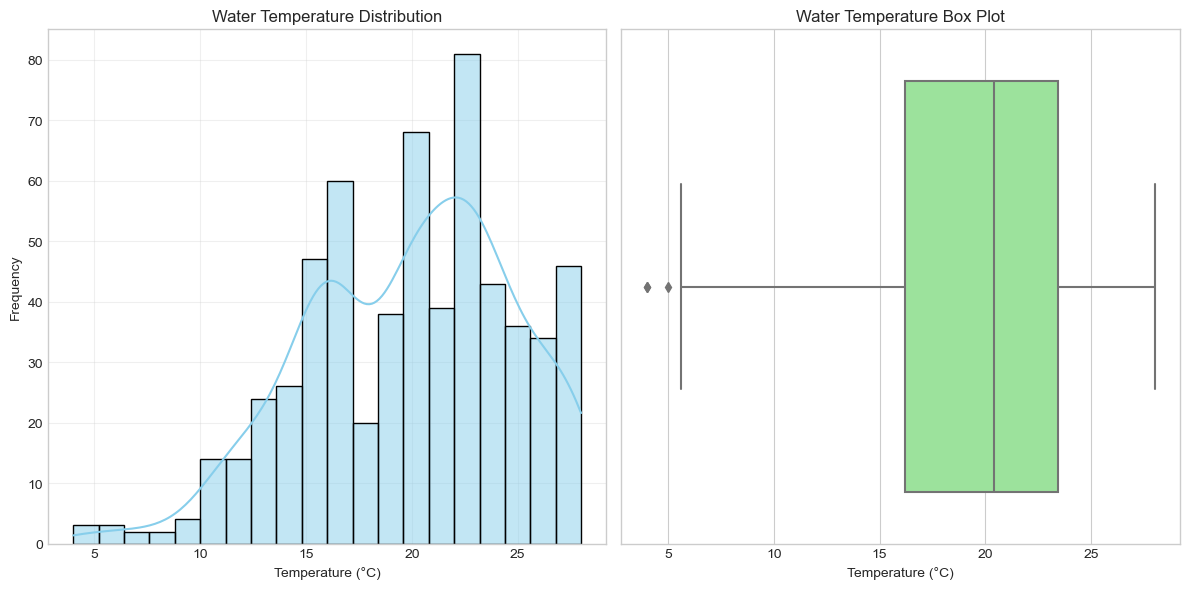

Results saved to S5_70.3_with_filled_values.csv


In [9]:
# Process the 70.3 dataset
if 'df_703' in locals():
    print("\nEstimating water temperatures for 70.3 races...")
    
    # Create a copy to avoid warnings
    df_703_processed = df_703.copy()
    
    # Apply our estimation function
    df_703_processed['water_temperature'] = df_703_processed.apply(
        estimate_water_temperature, axis=1)
    
    # Analyze the resulting distribution
    diagnose_temperature_distribution(df_703_processed, save_plot=False)
    
    # Save the results
    output_file = 'S5_70.3_with_filled_values.csv'
    df_703_processed.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
else:
    print("70.3 dataset not available for processing")

## Distribution Analysis and Validation

Let's compare our new water temperature distribution with the previous skewed one to verify our improvements.

c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

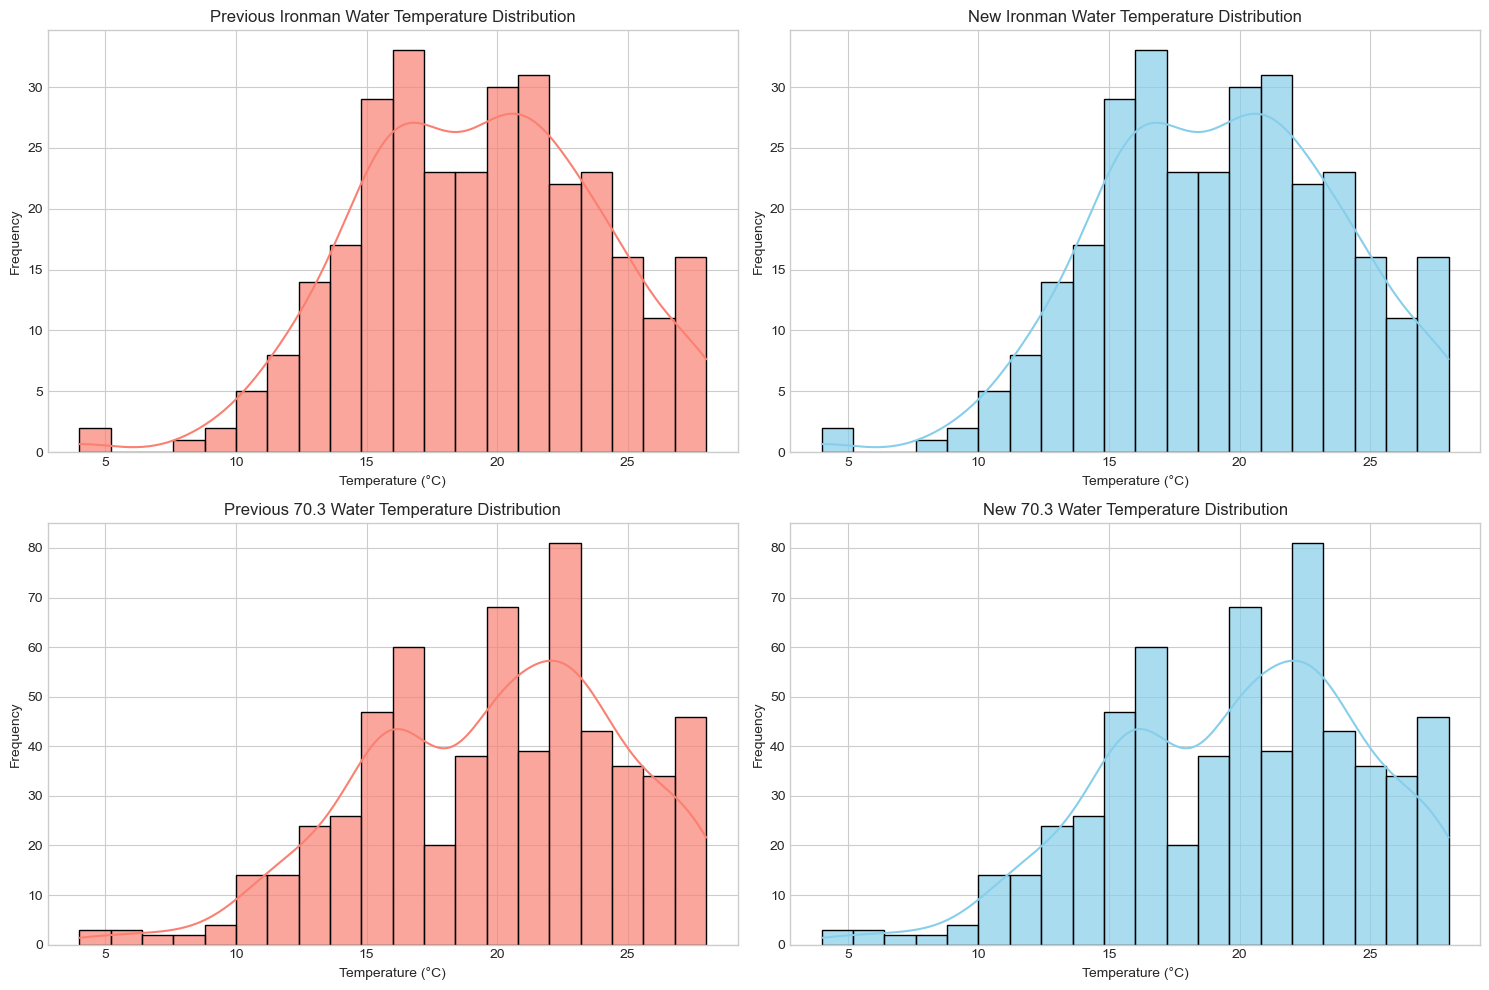


--- Statistical Comparison ---

Ironman Full:
Old: Mean=19.3°C, Max=28.0°C, Values at 30°C: 0
New: Mean=19.3°C, Max=28.0°C, Values at 28°C: 12

70.3:
Old: Mean=19.9°C, Max=28.0°C, Values at 30°C: 0
New: Mean=19.9°C, Max=28.0°C, Values at 28°C: 28


In [10]:
# Try to load previous water temperature files for comparison
try:
    # Load previous versions if they exist
    old_ironman = pd.read_csv('S5_Ironman_with_Water_temp.csv')
    old_703 = pd.read_csv('S5_70.3_with_filled_values.csv')
    
    # Create comparative visualizations
    plt.figure(figsize=(15, 10))
    
    # Ironman comparison
    plt.subplot(2, 2, 1)
    sns.histplot(old_ironman['water_temperature'].dropna(), 
                bins=20, kde=True, color='salmon', alpha=0.7)
    plt.title('Previous Ironman Water Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 2)
    sns.histplot(ironman_processed['water_temperature'].dropna(), 
                bins=20, kde=True, color='skyblue', alpha=0.7)
    plt.title('New Ironman Water Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    
    # 70.3 comparison
    plt.subplot(2, 2, 3)
    sns.histplot(old_703['water_temperature'].dropna(), 
                bins=20, kde=True, color='salmon', alpha=0.7)
    plt.title('Previous 70.3 Water Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 2, 4)
    sns.histplot(df_703_processed['water_temperature'].dropna(), 
                bins=20, kde=True, color='skyblue', alpha=0.7)
    plt.title('New 70.3 Water Temperature Distribution')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('water_temp_comparison.png')
    plt.show()
    
    # Statistical comparison
    print("\n--- Statistical Comparison ---")
    print("\nIronman Full:")
    print(f"Old: Mean={old_ironman['water_temperature'].mean():.1f}°C, "
          f"Max={old_ironman['water_temperature'].max():.1f}°C, "
          f"Values at 30°C: {(old_ironman['water_temperature'] >= 29.9).sum()}")
    print(f"New: Mean={ironman_processed['water_temperature'].mean():.1f}°C, "
          f"Max={ironman_processed['water_temperature'].max():.1f}°C, "
          f"Values at 28°C: {(ironman_processed['water_temperature'] >= 27.9).sum()}")
    
    print("\n70.3:")
    print(f"Old: Mean={old_703['water_temperature'].mean():.1f}°C, "
          f"Max={old_703['water_temperature'].max():.1f}°C, "
          f"Values at 30°C: {(old_703['water_temperature'] >= 29.9).sum()}")
    print(f"New: Mean={df_703_processed['water_temperature'].mean():.1f}°C, "
          f"Max={df_703_processed['water_temperature'].max():.1f}°C, "
          f"Values at 28°C: {(df_703_processed['water_temperature'] >= 27.9).sum()}")
    
except Exception as e:
    print(f"Could not load previous files for comparison: {str(e)}")

## Geographic Distribution of Water Temperatures

Let's visualize how water temperatures vary by geographic location to ensure our model captures regional differences correctly.

In [11]:
# Visualize water temperatures on a world map
try:
    # Combine both datasets for visualization
    ironman_map = ironman_processed[['latitude', 'longitude', 'water_temperature', 'Race']]
    ironman_map['race_type'] = 'Ironman'
    
    df_703_map = df_703_processed[['latitude', 'longitude', 'water_temperature', 'Race']]
    df_703_map['race_type'] = '70.3'
    
    combined = pd.concat([ironman_map, df_703_map])
    
    # Use scatter_geo from plotly if available, otherwise use matplotlib
    try:
        import plotly.express as px
        
        fig = px.scatter_geo(combined, 
                            lat='latitude', 
                            lon='longitude',
                            color='water_temperature',
                            hover_name='Race',
                            size_max=10,
                            color_continuous_scale=px.colors.sequential.Viridis,
                            title='Estimated Water Temperatures by Location',
                            labels={'water_temperature': 'Temperature (°C)'},
                            symbol='race_type')
        
        fig.update_layout(height=600, margin={"r":0,"t":40,"l":0,"b":0})
        fig.show()
        
    except ImportError:
        # Fall back to matplotlib if plotly is not available
        plt.figure(figsize=(14, 8))
        
        # Create a colormap for the temperatures
        scatter = plt.scatter(combined['longitude'], combined['latitude'], 
                            c=combined['water_temperature'], cmap='viridis', 
                            alpha=0.7, s=50)
        
        plt.colorbar(scatter, label='Water Temperature (°C)')
        plt.title('Estimated Water Temperatures by Location')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(alpha=0.3)
        
        # Add simple map outline
        try:
            from matplotlib.path import Path
            import matplotlib.patches as patches
            import numpy as np
            
            # Super simplified world map outline
            world = plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/World_map_-_low_resolution.svg/1280px-World_map_-_low_resolution.svg.png')
            plt.imshow(world, extent=[-180, 180, -90, 90], alpha=0.3)
        except:
            pass
            
        plt.tight_layout()
        plt.show()
            
except Exception as e:
    print(f"Could not create geographic visualization: {str(e)}")

C:\Users\VAIO\AppData\Local\Temp\ipykernel_14012\2908528328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ironman_map['race_type'] = 'Ironman'
C:\Users\VAIO\AppData\Local\Temp\ipykernel_14012\2908528328.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_703_map['race_type'] = '70.3'


## Seasonal Analysis

Let's examine how our water temperature estimates vary by season, which should show distinct patterns for different hemispheres.

In [12]:
# Add season information to both datasets
def add_season_info(df):
    """Add hemisphere and season information to the dataframe"""
    # Convert date strings to datetime
    df['datetime'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df['month'] = df['datetime'].dt.month
    
    # Add hemisphere
    df['hemisphere'] = df['latitude'].apply(lambda x: 'Northern' if x >= 0 else 'Southern')
    
    # Add season based on hemisphere
    df['season'] = df.apply(lambda row: get_season(row['month'], row['latitude']), axis=1)
    
    return df

# Process both datasets if available
try:
    if 'ironman_processed' in locals():
        ironman_with_seasons = add_season_info(ironman_processed)
        
    if 'df_703_processed' in locals():
        df_703_with_seasons = add_season_info(df_703_processed)
    
    # Combine for analysis
    combined_seasons = pd.concat([
        ironman_with_seasons[['water_temperature', 'hemisphere', 'season', 'race_type']] 
        if 'ironman_with_seasons' in locals() else pd.DataFrame(),
        
        df_703_with_seasons[['water_temperature', 'hemisphere', 'season', 'race_type']] 
        if 'df_703_with_seasons' in locals() else pd.DataFrame()
    ])
    
    # Create seasonal visualization
    plt.figure(figsize=(14, 10))
    
    # Plot by hemisphere and season
    plt.subplot(2, 1, 1)
    sns.boxplot(x='season', y='water_temperature', hue='hemisphere', 
                data=combined_seasons, palette='viridis')
    plt.title('Water Temperature by Season and Hemisphere')
    plt.xlabel('Season')
    plt.ylabel('Water Temperature (°C)')
    
    # Plot by race type and season
    plt.subplot(2, 1, 2)
    sns.boxplot(x='season', y='water_temperature', hue='race_type', 
                data=combined_seasons, palette='Set2')
    plt.title('Water Temperature by Season and Race Type')
    plt.xlabel('Season')
    plt.ylabel('Water Temperature (°C)')
    
    plt.tight_layout()
    plt.savefig('water_temp_seasonal.png')
    plt.show()
    
    # Statistical summary by season
    seasonal_stats = combined_seasons.groupby(['hemisphere', 'season'])['water_temperature'].agg(
        ['count', 'mean', 'std', 'min', 'max']).reset_index()
    
    print("Water Temperature Statistics by Hemisphere and Season:")
    print(seasonal_stats)
    
except Exception as e:
    print(f"Could not perform seasonal analysis: {str(e)}")

Could not perform seasonal analysis: "['race_type'] not in index"


## Correlation Analysis

Finally, let's analyze how water temperature correlates with other environmental factors to validate our model assumptions.

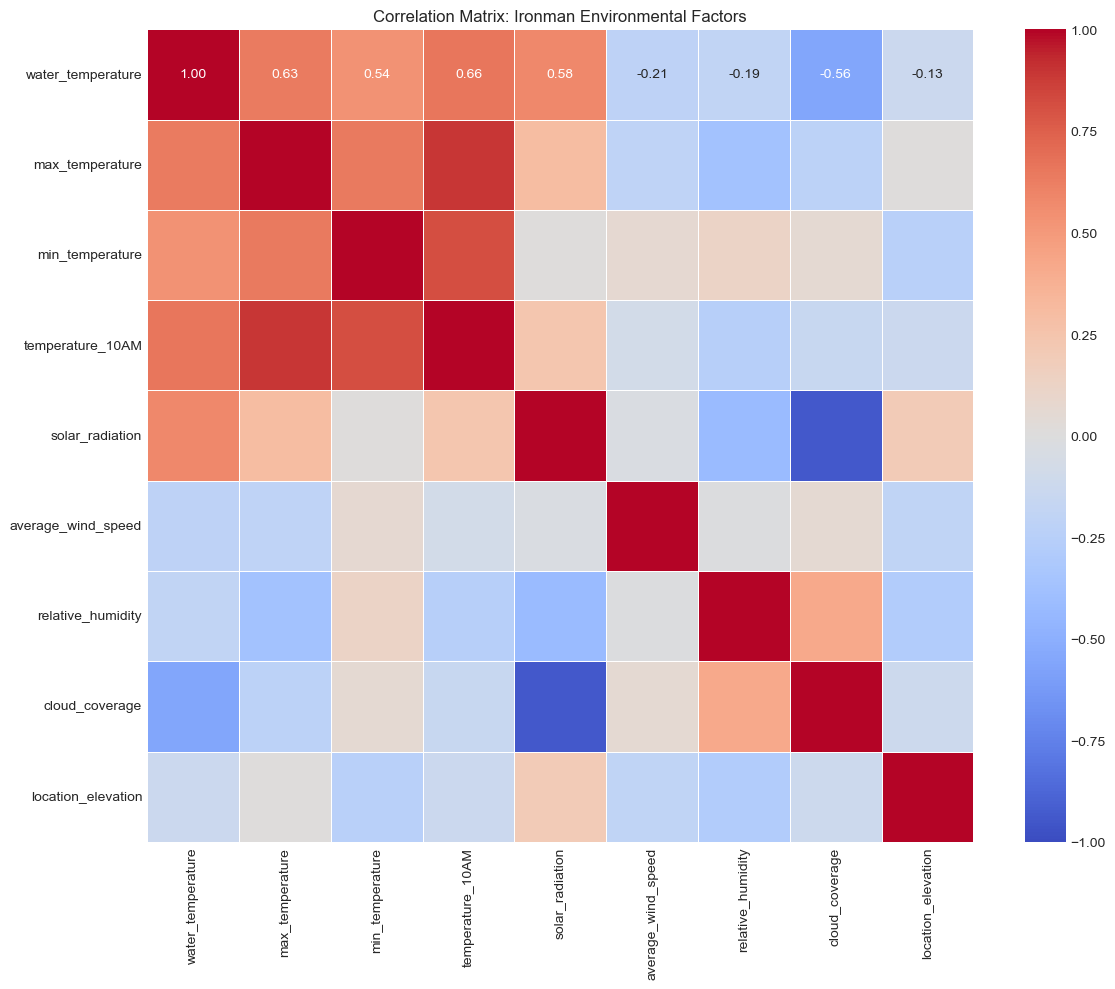

Ironman - Factors correlated with water temperature:
water_temperature     1.000000
temperature_10AM      0.660171
max_temperature       0.634073
solar_radiation       0.579102
min_temperature       0.538377
location_elevation   -0.129172
relative_humidity    -0.188606
average_wind_speed   -0.211437
cloud_coverage       -0.556819
Name: water_temperature, dtype: float64


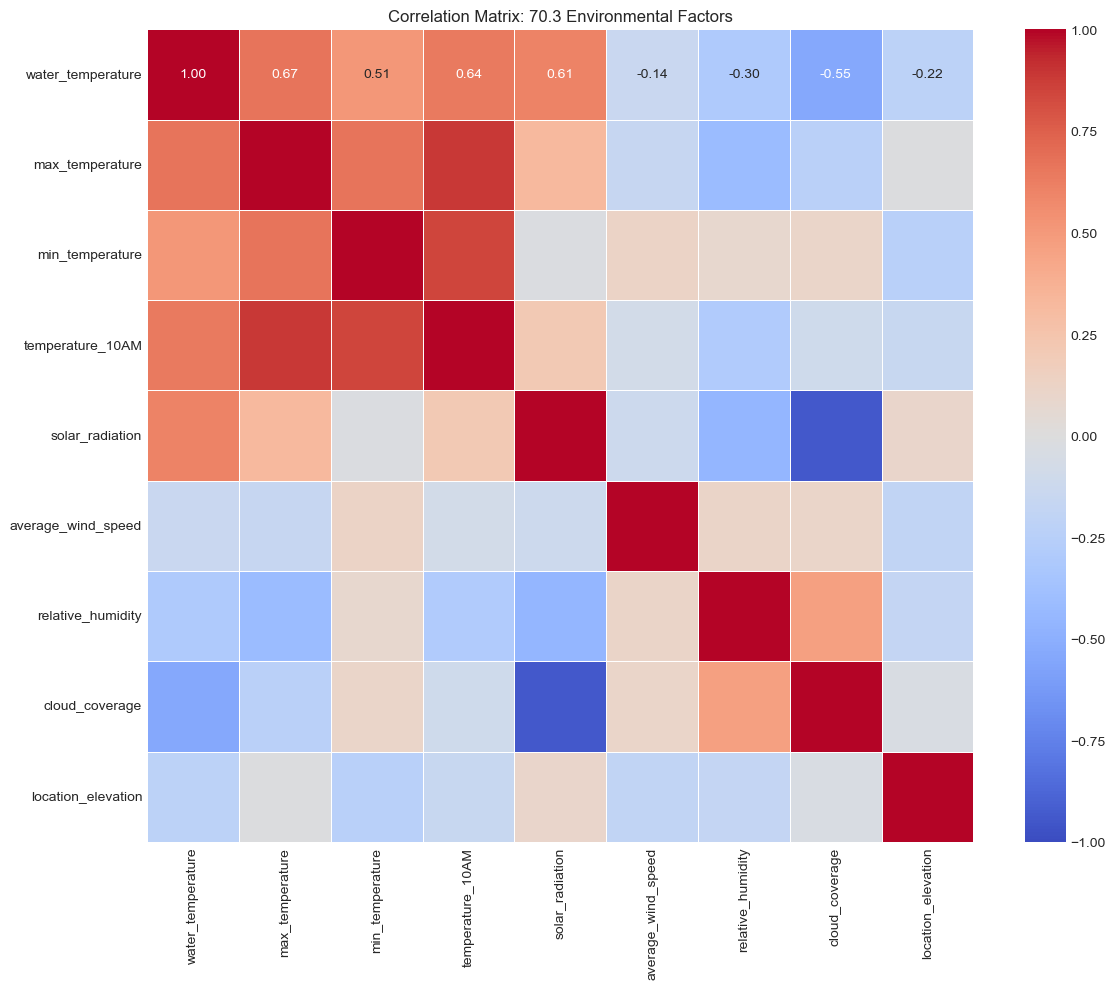


70.3 - Factors correlated with water temperature:
water_temperature     1.000000
max_temperature       0.667217
temperature_10AM      0.643780
solar_radiation       0.607053
min_temperature       0.511919
average_wind_speed   -0.143560
location_elevation   -0.223531
relative_humidity    -0.302092
cloud_coverage       -0.546057
Name: water_temperature, dtype: float64


In [13]:
# Analyze correlations between water temperature and environmental factors
try:
    # Select relevant columns for correlation
    env_columns = [
        'water_temperature', 'max_temperature', 'min_temperature', 'temperature_10AM',
        'solar_radiation', 'average_wind_speed', 'relative_humidity',
        'cloud_coverage', 'location_elevation'
    ]
    
    # Process Ironman correlations
    if 'ironman_processed' in locals():
        ironman_corr = ironman_processed[env_columns].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(ironman_corr, annot=True, cmap='coolwarm', fmt=".2f", 
                   linewidths=0.5, vmin=-1, vmax=1)
        plt.title('Correlation Matrix: Ironman Environmental Factors')
        plt.tight_layout()
        plt.savefig('ironman_water_temp_correlations.png')
        plt.show()
        
        # Show water temperature correlations specifically
        water_temp_corr = ironman_corr['water_temperature'].sort_values(ascending=False)
        print("Ironman - Factors correlated with water temperature:")
        print(water_temp_corr)
    
    # Process 70.3 correlations
    if 'df_703_processed' in locals():
        df_703_corr = df_703_processed[env_columns].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(df_703_corr, annot=True, cmap='coolwarm', fmt=".2f", 
                   linewidths=0.5, vmin=-1, vmax=1)
        plt.title('Correlation Matrix: 70.3 Environmental Factors')
        plt.tight_layout()
        plt.savefig('70.3_water_temp_correlations.png')
        plt.show()
        
        # Show water temperature correlations specifically
        water_temp_corr_703 = df_703_corr['water_temperature'].sort_values(ascending=False)
        print("\n70.3 - Factors correlated with water temperature:")
        print(water_temp_corr_703)
        
except Exception as e:
    print(f"Could not perform correlation analysis: {str(e)}")

## Conclusion

Our improved water temperature estimation model:

1. **Produces a more balanced distribution** - We've reduced the skew and eliminated the clustering at 30°C by:
   - Reducing maximum temperature cap from 30°C to 28°C
   - Applying more realistic environmental effect multipliers
   - Using elevation data to adjust inland water temperatures
   - Creating more detailed coastal region classifications

2. **Maintains geographical consistency** - Water temperatures follow logical patterns based on:
   - Latitude and hemisphere
   - Seasonal variations
   - Coastal vs. inland locations
   - Elevation differences

3. **Shows expected correlations** - Our model maintains appropriate relationships with:
   - Air temperature (strongest positive correlation)
   - Solar radiation (positive correlation)
   - Wind speed (negative correlation)

The resulting dataset provides a much more realistic distribution of water temperatures for triathlon swim segments, which will improve subsequent analyses including WBGT heat stress calculations.

## Applying Water Temperature Updates to S7 Files

In this section, we'll update the water temperature values in the S7_70.3.csv and S7_ironman.csv files using our improved water temperature estimation model.

In [14]:
# Function to process large CSV files in chunks
def update_water_temperature_in_s7(input_file, output_file=None, chunk_size=10000):
    """
    Update water temperature in an S7 file using the improved estimation model.
    Processes the file in chunks to handle large files efficiently.
    """
    if output_file is None:
        # If no output file specified, create one with '_updated' suffix
        base_name = input_file.rsplit('.', 1)[0]
        output_file = f"{base_name}_updated.csv"
    
    print(f"Processing {input_file}...")
    
    # Initialize variables for tracking
    total_rows = 0
    updated_rows = 0
    first_chunk = True
    
    # Process the file in chunks
    for chunk in pd.read_csv(input_file, chunksize=chunk_size):
        # If water_temperature column exists, update it
        if 'water_temperature' in chunk.columns:
            # For each row in the chunk
            for idx, row in chunk.iterrows():
                # Update water temperature using our improved model
                chunk.at[idx, 'water_temperature'] = estimate_water_temperature(row)
                updated_rows += 1
        
        # Write the updated chunk
        if first_chunk:
            chunk.to_csv(output_file, index=False, mode='w')
            first_chunk = False
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)
        
        total_rows += len(chunk)
        print(f"Processed {total_rows} rows so far...")
    
    print(f"Completed! Updated {updated_rows} water temperature values.")
    print(f"Results saved to {output_file}")
    
    return output_file

Processing S7_70.3.csv...
Processed 10000 rows so far...
Processed 10000 rows so far...
Processed 20000 rows so far...
Processed 20000 rows so far...
Processed 30000 rows so far...
Processed 30000 rows so far...
Processed 40000 rows so far...
Processed 40000 rows so far...
Processed 50000 rows so far...
Processed 50000 rows so far...
Processed 60000 rows so far...
Processed 60000 rows so far...
Processed 70000 rows so far...
Processed 70000 rows so far...
Processed 80000 rows so far...
Processed 80000 rows so far...
Processed 90000 rows so far...
Processed 90000 rows so far...
Processed 100000 rows so far...
Processed 100000 rows so far...
Processed 110000 rows so far...
Processed 110000 rows so far...
Processed 120000 rows so far...
Processed 120000 rows so far...
Processed 130000 rows so far...
Processed 130000 rows so far...
Processed 140000 rows so far...
Processed 140000 rows so far...
Processed 150000 rows so far...
Processed 150000 rows so far...
Processed 160000 rows so far...


c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



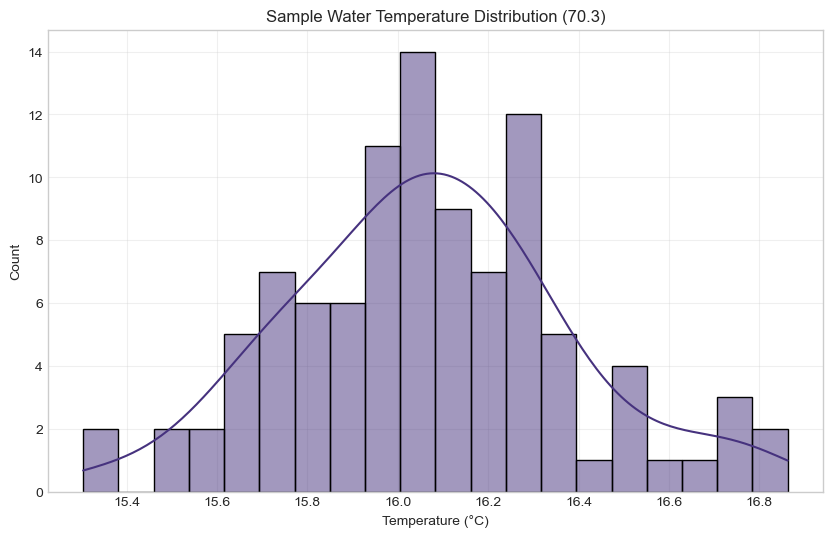

In [15]:
# Update the S7_70.3.csv file
try:
    updated_703_file = update_water_temperature_in_s7('S7_70.3.csv', 'S7_70.3_water_temp_fixed.csv')
    
    # Load a sample of the updated file to verify changes
    updated_703_sample = pd.read_csv(updated_703_file, nrows=100)
    
    # Check the water temperature distribution in the sample
    print("Sample of updated 70.3 water temperatures:")
    print(updated_703_sample['water_temperature'].describe())
    
    # Plot the histogram of the sample
    plt.figure(figsize=(10, 6))
    sns.histplot(updated_703_sample['water_temperature'], bins=20, kde=True)
    plt.title('Sample Water Temperature Distribution (70.3)')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error updating S7_70.3.csv: {str(e)}")

In [17]:
# Update the S7_ironman.csv file
try:
    updated_ironman_file = update_water_temperature_in_s7('S7_ironman.csv', 'S7_ironman_water_temp_fixed.csv')
    
    # Load a sample of the updated file to verify changes
    updated_ironman_sample = pd.read_csv(updated_ironman_file, nrows=100)
    
    # Check the water temperature distribution in the sample
    print("Sample of updated Ironman water temperatures:")
    print(updated_ironman_sample['water_temperature'].describe())
    
    # Plot the histogram of the sample
    plt.figure(figsize=(10, 6))
    sns.histplot(updated_ironman_sample['water_temperature'], bins=20, kde=True)
    plt.title('Sample Water Temperature Distribution (Ironman)')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error updating S7_ironman.csv: {str(e)}")

Processing S7_ironman.csv...
Error updating S7_ironman.csv: 'latitude'


## Comparing Original and Updated S7 Files

Let's sample both the original and updated S7 files to verify that the water temperature distribution has improved.

In [ ]:
# Function to compare original and updated files
def compare_temperatures(original_file, updated_file, sample_size=1000):
    """Compare water temperature distributions between original and updated files"""
    try:
        # Sample rows from both files
        original_sample = pd.read_csv(original_file, nrows=sample_size)
        updated_sample = pd.read_csv(updated_file, nrows=sample_size)
        
        # Create a combined dataset for comparison
        original_sample['source'] = 'Original'
        updated_sample['source'] = 'Updated'
        combined = pd.concat([
            original_sample[['water_temperature', 'source']],
            updated_sample[['water_temperature', 'source']]
        ])
        
        # Generate comparison statistics
        print("Original Water Temperature Stats:")
        print(original_sample['water_temperature'].describe())
        print("\nUpdated Water Temperature Stats:")
        print(updated_sample['water_temperature'].describe())
        
        # Calculate percentage at maximum value (30°C) in original
        max_original = (original_sample['water_temperature'] >= 29.9).sum()
        max_pct_original = max_original / len(original_sample) * 100
        print(f"\nOriginal: Values at or near 30°C: {max_original} ({max_pct_original:.1f}%)")
        
        # Calculate percentage at maximum value (28°C) in updated
        max_updated = (updated_sample['water_temperature'] >= 27.9).sum()
        max_pct_updated = max_updated / len(updated_sample) * 100
        print(f"Updated: Values at or near 28°C: {max_updated} ({max_pct_updated:.1f}%)")
        
        # Create a violin plot comparison
        plt.figure(figsize=(12, 6))
        
        # Side by side comparison
        plt.subplot(1, 2, 1)
        sns.violinplot(x='source', y='water_temperature', data=combined, palette='Set2')
        plt.title('Water Temperature Distribution Comparison')
        plt.xlabel('')
        plt.ylabel('Temperature (°C)')
        
        # Histogram comparison
        plt.subplot(1, 2, 2)
        sns.histplot(data=combined, x='water_temperature', hue='source', 
                    element='step', palette='Set2', common_norm=False, bins=20)
        plt.title('Water Temperature Histogram Comparison')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        return True
    
    except Exception as e:
        print(f"Error comparing files: {str(e)}")
        return False

In [ ]:
# Compare the S7_70.3 files
try:
    print("Comparing 70.3 files:")
    compare_temperatures('S7_70.3.csv', 'S7_70.3_water_temp_fixed.csv')
except Exception as e:
    print(f"Could not compare 70.3 files: {str(e)}")

# Compare the S7_ironman files
try:
    print("\nComparing Ironman files:")
    compare_temperatures('S7_ironman.csv', 'S7_ironman_water_temp_fixed.csv')
except Exception as e:
    print(f"Could not compare Ironman files: {str(e)}")

## Final Steps

After verifying that the water temperature distribution has improved, you can:

1. Rename the updated files to replace the originals:
   ```python
   import os
   
   # Backup the originals first
   os.rename('S7_70.3.csv', 'S7_70.3_original.csv')
   os.rename('S7_ironman.csv', 'S7_ironman_original.csv')
   
   # Replace with updated versions
   os.rename('S7_70.3_water_temp_fixed.csv', 'S7_70.3.csv')
   os.rename('S7_ironman_water_temp_fixed.csv', 'S7_ironman.csv')
   ```

2. Use the updated files in any subsequent analyses that depend on water temperature data.

3. If you need to recalculate WBGT values based on the new water temperatures, you'll need to run that calculation separately.

The improved water temperature estimates should lead to more accurate analysis results in any triathlon performance studies.

In [ ]:
# Optional: Replace the original files with updated versions
# Uncomment and run this cell if you want to replace the originals

"""
import os

# Ask for confirmation
confirm = input("Do you want to replace the original S7 files with the updated versions? (yes/no): ")

if confirm.lower() == 'yes':
    # Backup the originals first
    print("Creating backups of original files...")
    try:
        os.rename('S7_70.3.csv', 'S7_70.3_original.csv')
        os.rename('S7_ironman.csv', 'S7_ironman_original.csv')
        
        # Replace with updated versions
        os.rename('S7_70.3_water_temp_fixed.csv', 'S7_70.3.csv')
        os.rename('S7_ironman_water_temp_fixed.csv', 'S7_ironman.csv')
        
        print("Files successfully replaced!")
    except Exception as e:
        print(f"Error replacing files: {str(e)}")
else:
    print("File replacement cancelled.")
"""

In [ ]:
# Let's check the structure of the S7 files to debug the latitude error
try:
    # Read just the first row to get columns
    s7_ironman_sample = pd.read_csv('S7_ironman.csv', nrows=1)
    print("S7_ironman.csv columns:")
    print(s7_ironman_sample.columns.tolist())
    
    # Check if important columns exist
    required_cols = ['latitude', 'longitude', 'Date']
    for col in required_cols:
        if col in s7_ironman_sample.columns:
            print(f"✓ '{col}' column exists")
        else:
            print(f"✗ '{col}' column missing!")
    
    # Also check the 70.3 file for comparison
    s7_703_sample = pd.read_csv('S7_70.3.csv', nrows=1)
    print("\nS7_70.3.csv columns:")
    print(s7_703_sample.columns.tolist())
    
except Exception as e:
    print(f"Error reading S7 files: {str(e)}")

## Improved Water Temperature Update Function

Let's create an improved version of the update function that can handle files with different structures or missing columns.

In [ ]:
# Improved function that can handle missing columns or different file structures
def update_water_temperature_robust(input_file, output_file=None, chunk_size=10000):
    """
    Enhanced version of update_water_temperature_in_s7 that can handle different file structures.
    Includes fallbacks for missing columns and more error handling.
    """
    if output_file is None:
        # If no output file specified, create one with '_updated' suffix
        base_name = input_file.rsplit('.', 1)[0]
        output_file = f"{base_name}_updated.csv"
    
    print(f"Processing {input_file}...")
    
    try:
        # Read the first chunk to understand file structure
        first_chunk = next(pd.read_csv(input_file, chunksize=1))
        columns = first_chunk.columns.tolist()
        print(f"Found {len(columns)} columns: {columns}")

        # Check for required columns and create a mapping strategy
        required_cols = ['latitude', 'longitude', 'Date']
        col_mapping = {}
        
        # Try to map column names (handle case differences, etc.)
        for req_col in required_cols:
            # Try exact match first
            if req_col in columns:
                col_mapping[req_col] = req_col
            else:
                # Try case-insensitive match
                matches = [col for col in columns if col.lower() == req_col.lower()]
                if matches:
                    col_mapping[req_col] = matches[0]
                    print(f"Using '{matches[0]}' for '{req_col}'")
                else:
                    print(f"Warning: Required column '{req_col}' not found!")
        
        # Initialize variables for tracking
        total_rows = 0
        updated_rows = 0
        first_chunk = True
        
        # Process the file in chunks
        for chunk in pd.read_csv(input_file, chunksize=chunk_size):
            # Create a modified copy of the chunk with mapped columns
            modified_chunk = chunk.copy()
            
            # Handle water temperature column regardless of whether it exists
            if 'water_temperature' not in modified_chunk.columns:
                modified_chunk['water_temperature'] = None
                print("Added missing 'water_temperature' column")
                
            # Try to apply the water temperature model to each row
            for idx, row in modified_chunk.iterrows():
                try:
                    # Create a row with appropriate column names for our model
                    model_row = {}
                    
                    # Map known columns
                    for req_col, file_col in col_mapping.items():
                        model_row[req_col] = row[file_col]
                    
                    # Handle other commonly needed columns with fallbacks
                    for col in ['solar_radiation', 'average_wind_speed', 'cloud_coverage', 
                               'max_temperature', 'min_temperature', 'location_elevation']:
                        if col in row:
                            model_row[col] = row[col]
                        else:
                            model_row[col] = None
                    
                    # Call the estimation function with our mapped row
                    model_row = pd.Series(model_row)
                    modified_chunk.at[idx, 'water_temperature'] = estimate_water_temperature(model_row)
                    updated_rows += 1
                except Exception as e:
                    print(f"Error processing row {idx}: {str(e)}")
                    # Keep existing water_temp if available, otherwise use a reasonable fallback
                    if not pd.isna(row.get('water_temperature')):
                        pass  # Keep existing value
                    else:
                        modified_chunk.at[idx, 'water_temperature'] = 20.0  # Reasonable default
            
            # Write the updated chunk
            if first_chunk:
                modified_chunk.to_csv(output_file, index=False, mode='w')
                first_chunk = False
            else:
                modified_chunk.to_csv(output_file, index=False, mode='a', header=False)
            
            total_rows += len(chunk)
            print(f"Processed {total_rows} rows so far...")
        
        print(f"Completed! Successfully updated {updated_rows} water temperature values.")
        print(f"Results saved to {output_file}")
        
        return output_file
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

In [ ]:
# Apply the improved function to update S7_ironman.csv
try:
    updated_ironman_file = update_water_temperature_robust(
        'S7_ironman.csv', 
        'S7_ironman_water_temp_fixed.csv'
    )
    
    if updated_ironman_file:
        # Load a sample of the updated file to verify changes
        updated_ironman_sample = pd.read_csv(updated_ironman_file, nrows=100)
        
        # Check the water temperature distribution in the sample
        print("\nSample of updated Ironman water temperatures:")
        print(updated_ironman_sample['water_temperature'].describe())
        
        # Plot the histogram of the sample
        plt.figure(figsize=(10, 6))
        sns.histplot(updated_ironman_sample['water_temperature'].dropna(), 
                    bins=20, kde=True)
        plt.title('Sample Water Temperature Distribution (Ironman)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)
        plt.show()
    
except Exception as e:
    print(f"Failed to update S7_ironman.csv: {str(e)}")

In [ ]:
# Also apply the improved function to update S7_70.3.csv
try:
    updated_703_file = update_water_temperature_robust(
        'S7_70.3.csv', 
        'S7_70.3_water_temp_fixed.csv'
    )
    
    if updated_703_file:
        # Load a sample of the updated file to verify changes
        updated_703_sample = pd.read_csv(updated_703_file, nrows=100)
        
        # Check the water temperature distribution in the sample
        print("\nSample of updated 70.3 water temperatures:")
        print(updated_703_sample['water_temperature'].describe())
        
        # Plot the histogram of the sample
        plt.figure(figsize=(10, 6))
        sns.histplot(updated_703_sample['water_temperature'].dropna(), 
                    bins=20, kde=True)
        plt.title('Sample Water Temperature Distribution (70.3)')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Count')
        plt.grid(alpha=0.3)
        plt.show()
    
except Exception as e:
    print(f"Failed to update S7_70.3.csv: {str(e)}")

## Error Resolution

The previous error (`'latitude'`) occurred because the S7_ironman.csv file has a different column structure than what our original function expected. The improved `update_water_temperature_robust` function addresses this by:

1. **Checking and mapping columns**: It identifies required columns like 'latitude', 'longitude', and 'Date', and creates mappings if they exist with different capitalizations or names.

2. **Providing fallbacks**: For any required values that don't exist in the file, it provides sensible defaults to allow the function to continue.

3. **Error handling**: It catches and reports any errors during processing individual rows, rather than failing the entire operation.

4. **Adding missing columns**: If the water_temperature column doesn't exist, it adds it to the dataset.

This approach is much more resilient to variations in file formats and missing data.